In [1]:
import json
from pathlib import Path
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import utm

In [2]:
ESTIMATED_CENTER_LAT = 43.690660
ESTIMATED_CENTER_LON = -79.395199
EARTH_RADIUS = 6371 #km

DOWNTOWN_LAT = 43.656236
DOWNTOWN_LON = -79.388837

In [3]:
def lat_lon_to_global_x_y(lat, lon):
    # convert lat and lon coordinates to global X and Y in kilometers
    x = EARTH_RADIUS * math.cos(lat) * math.cos(lon)
    y = EARTH_RADIUS * math.cos(lat) * math.sin(lon)
    return x, y

In [4]:
# read shop locations and information
shops_info = []
with open(Path("./Datasets/shop_locations.csv"), mode='r', encoding='utf-8') as shop_locations_file:
    csvshopreader = csv.reader(shop_locations_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    line_number = 0
    for row in csvshopreader:
        if line_number == 0:
            print("Reading shop locations file")
            line_number += 1
        else:
            shop_id = line_number - 1
            shop_lat = float(row[1])
            shop_lon = float(row[2])
            shop_weight = int(float(row[3]))
            shops_info.append([shop_id, shop_lat, shop_lon, shop_weight])

Reading shop locations file


In [5]:
# read road and walkable network nodes and their population/population density
population_info = []
with open(Path("./Datasets/per_node_population_density.csv"), mode='r', encoding='utf-8') as population_density_file:
    csvpopulationreader = csv.reader(population_density_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    line_number = 0
    for row in csvpopulationreader:
        if line_number == 0:
            print("Reading population density file")
            line_number += 1
        else:
            node_id = line_number - 1
            node_osmid = float(row[1])
            node_lat = float(row[3])
            node_lon = float(row[2])
            node_population = int(float(row[12]))
            node_popdensity = int(float(row[13]))
            population_info.append([node_id, node_osmid, node_lat, node_lon, node_population, node_popdensity])
print("Read data files!")
print("Found " + str(len(shops_info)) + " shop data")
print("Found " + str(len(population_info)) + " population node data")

Reading population density file
Read data files!
Found 23702 shop data
Found 5797 population node data


In [6]:
# calculate center of map
sum_lat = 0
sum_lon = 0
for population in population_info:
    population_lat = population[2]
    population_lon = population[3]
    sum_lat += population_lat
    sum_lon += population_lon
map_center_lat = sum_lat / len(population_info)
map_center_lon = sum_lon / len(population_info)

# convert latitudes and longitudes to global X and Y coordinates, then convert to cartesian 
# coordinates based on known center of bounding box being used. All for ease of use with facility
# placement optimization algorithms
map_center_x, map_center_y = lat_lon_to_global_x_y(map_center_lat, map_center_lon)

In [7]:
shop_info_x_y = []
for shop_info in shops_info:
    shop_lat = shop_info[1]
    shop_lon = shop_info[2]
    shop_x, shop_y = lat_lon_to_global_x_y(shop_lat, shop_lon)
    cartesian_x = shop_x - map_center_x
    cartesian_y = shop_y - map_center_y
    shop_info[1] = cartesian_x
    shop_info[2] = cartesian_y
    shop_info_x_y.append(shop_info)

population_info_x_y = []
for population in population_info:
    population_lat = population[2]
    population_lon = population[3]
    population_x, population_y = lat_lon_to_global_x_y(population_lat, population_lon)
    cartesian_x = population_x - map_center_x
    cartesian_y = population_y - map_center_y
    population[2] = cartesian_x
    population[3] = cartesian_y
    population_info_x_y.append(population)

print("Converted latitude and longitude coordinates to global X, Y coordinates and adjusted them based on a centroid value to cartesian coordinates")

Converted latitude and longitude coordinates to global X, Y coordinates and adjusted them based on a centroid value to cartesian coordinates


In [8]:
# now that we have shops and population density nodes in cartesian coordinates, we can start 
# computing a synthetic demand weight to generate synthetic demand based on a probabilistic generation function

# first, we need to calculate shop density around each population density node to be able to use the information
# in the probabilistic generation function
# to do that, we'll estimate a radius around each node within which delivery demand could be affected by shop density in the area
# while this will cause some shops to be accounted several times for, this is fine as demand will be generated probabilistically for 
# every node
MAX_SHOP_RADIUS = 1
population_node_shop_weighted = []
node_index = 0
total_shop_weight = 0
max_shop_weight = 0
for node in population_info_x_y:
    node_x = node[2]
    node_y = node[3]
    total_node_shop_weight = 0
    for shop in shop_info_x_y:
        shop_x = shop[1]
        shop_y = shop[2]
        if shop_x >= node_x - MAX_SHOP_RADIUS and shop_x <= node_x + MAX_SHOP_RADIUS:
            if shop_y >= node_y - MAX_SHOP_RADIUS and shop_y <= node_y + MAX_SHOP_RADIUS:
                total_node_shop_weight += int(shop[3])
                total_shop_weight += int(shop[3])
    node.append(total_node_shop_weight)
    if total_node_shop_weight > max_shop_weight:
        max_shop_weight = total_node_shop_weight
    population_node_shop_weighted.append(node)
    print("Completed Node " + str(node_index))
    node_index += 1
print("Average shop weight per node is: " + str(float(total_shop_weight) / len(population_node_shop_weighted)))
print("Max shop weight is: " + str(max_shop_weight))

Completed Node 0
Completed Node 1
Completed Node 2
Completed Node 3
Completed Node 4
Completed Node 5
Completed Node 6
Completed Node 7
Completed Node 8
Completed Node 9
Completed Node 10
Completed Node 11
Completed Node 12
Completed Node 13
Completed Node 14
Completed Node 15
Completed Node 16
Completed Node 17
Completed Node 18
Completed Node 19
Completed Node 20
Completed Node 21
Completed Node 22
Completed Node 23
Completed Node 24
Completed Node 25
Completed Node 26
Completed Node 27
Completed Node 28
Completed Node 29
Completed Node 30
Completed Node 31
Completed Node 32
Completed Node 33
Completed Node 34
Completed Node 35
Completed Node 36
Completed Node 37
Completed Node 38
Completed Node 39
Completed Node 40
Completed Node 41
Completed Node 42
Completed Node 43
Completed Node 44
Completed Node 45
Completed Node 46
Completed Node 47
Completed Node 48
Completed Node 49
Completed Node 50
Completed Node 51
Completed Node 52
Completed Node 53
Completed Node 54
Completed Node 55
Co

In [9]:
# now we know how many shops and how big they are around each network node. So now we can estimate a weight for each node based
# on a parameterized function!
SHOP_DENSITY_HYPERPARAMETER = 100
POPULATION_DENSITY_HYPERPARAMETER = 200
weighted_nodes = []
total_weight = 0.0
for node in population_node_shop_weighted:
    node_id = node[0]
    node_osmid = node[1]
    node_x = node[2]
    node_y = node[3]
    node_population = node[4]
    node_popdensity = node[5]
    node_shop_weight = node[6]
    node_weight = POPULATION_DENSITY_HYPERPARAMETER * node_popdensity + SHOP_DENSITY_HYPERPARAMETER * node_shop_weight
    total_weight += node_weight
    weighted_nodes.append([node_id, node_osmid, -node_x, -node_y, node_weight, 0]) # last element is the number of deliveries this node will have

In [10]:
# now let's calculate, based on each node's weight, the probability of creating a delivery for that node
node_probability_distribution = []
node_index = 0
for node in weighted_nodes:
    node_probability_distribution.append(node[4] / total_weight)
    weighted_nodes[node_index][4] = node[4] / total_weight
    node_index += 1

In [11]:
# calculate weighted center of map
sum_x = 0
sum_y = 0
for node in weighted_nodes:
    sum_x += (node[2]) * (node[4] / total_weight)
    sum_y += (node[3]) * (node[4] / total_weight)
cartesian_dtwn_x = sum_x / len(weighted_nodes)
cartesian_dtwn_y = sum_y / len(weighted_nodes)

In [12]:
# convert the probabilities to a numpy array and probabilistically distribute N deliveries between all the nodes
NUMBER_OF_DELIVERIES = 1000000
prob_distribution = np.array(node_probability_distribution)

distributed_deliveries_index = []
for index in range(0, len(prob_distribution)):
    distributed_deliveries_index.append(index)

choices = np.random.choice(distributed_deliveries_index, size=NUMBER_OF_DELIVERIES, p=prob_distribution)
for chosen_index in choices.tolist():
    weighted_nodes[chosen_index][5] += 1

# export the synthetic dataset to a .csv file for later use
with open('synthetic_dataset.csv', mode='w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'Number Deliveries'])
    for node in weighted_nodes:
        csvwriter.writerow(node)

x_coordinates = []
y_coordinates = []
num_deliveries = []
for node in weighted_nodes:
    x_coordinates.append(node[2])
    y_coordinates.append(node[3])
    num_deliveries.append(node[5])
max_deliveries = max(num_deliveries)
print("Max allocated number of deliveries to a node: " + str(max_deliveries))
min_deliveries = min(num_deliveries)
print("Min allocated number of deliveries to a node: " + str(min_deliveries))

Max allocated number of deliveries to a node: 1991
Min allocated number of deliveries to a node: 0


In [13]:
print("Downtown X,Y coordinates: " + str(cartesian_dtwn_x) + "," + str(cartesian_dtwn_y))

Downtown X,Y coordinates: -3.7178296565262885e-14,-2.6310964646970894e-13


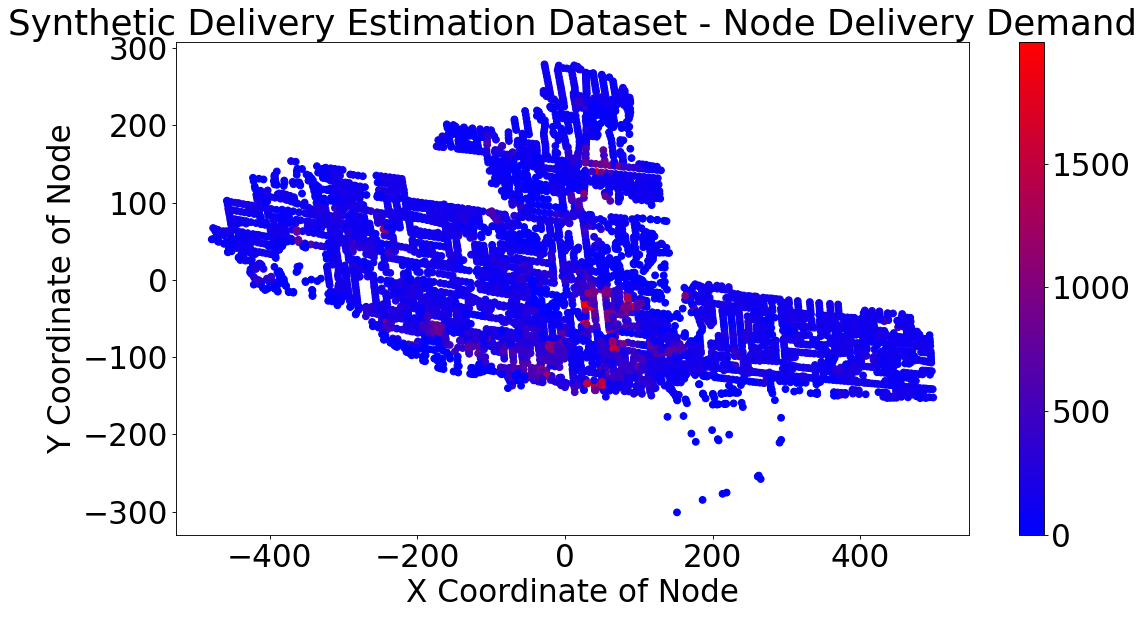

In [14]:
blue_red_colormap = LinearSegmentedColormap.from_list('BlueRed', ['b', 'r'])

large = 32; med = 28; small = 24
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)

plt.figure(figsize=(16,8), dpi= 80)
plt.ylabel("Y Coordinate of Node", fontsize=med)  
plt.xlabel("X Coordinate of Node", fontsize=med) 
plt.title("Synthetic Delivery Estimation Dataset - Node Delivery Demand", fontsize=large)

sc = plt.scatter(x_coordinates, y_coordinates, c=num_deliveries, vmin=min_deliveries, vmax=max_deliveries, cmap=blue_red_colormap)
plt.colorbar(sc)
plt.savefig("synthetic_dataset_visualization.svg", format="svg")
plt.show()